# Spooky Author Identification

In this project, lines from books authored by Edgar Allan Poe (EAP), Mary Shelley (MWS), or HP Lovecraft (HPL) are provided in 'train.csv'. A model will be built to predict the authors from the lines from 'test.csv'. Dataset from Kaggle.

In [548]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [549]:
df = pd.read_csv('./train.csv')

## Exploratory Data Analysis

In [550]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


<Axes: xlabel='author', ylabel='count'>

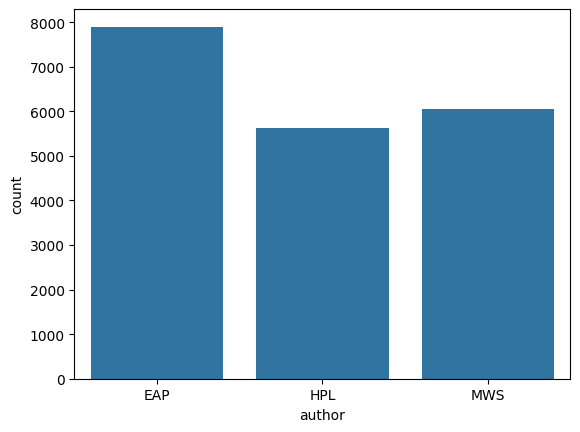

In [551]:
sns.countplot(df, x='author')

## Model Selection and Training

In [552]:
X = df['text']
y = df['author']

In [553]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.1, random_state=42)

In [554]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)

In [555]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

In [556]:
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [557]:
y_pred_probability = model.predict_proba(X_test_tfidf)
y_pred = model.predict(X_test_tfidf)

In [558]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, log_loss, ConfusionMatrixDisplay
print(classification_report(y_test, y_pred))
print(log_loss(pd.get_dummies(y_test), y_pred_probability))

              precision    recall  f1-score   support

         EAP       0.74      0.91      0.82       777
         HPL       0.91      0.69      0.78       524
         MWS       0.88      0.81      0.84       657

    accuracy                           0.82      1958
   macro avg       0.84      0.80      0.82      1958
weighted avg       0.83      0.82      0.82      1958

0.5845963763500455


c:\Users\K\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


### Hyperparameter Tuning

Above shows the metrics with the default settings. With the MultinomialNB model, one parameter that can be changed is the alpha smoothing parameter.

In [559]:
alpha = []
accuracy = []
f1 = []
loss_list = []

for i in np.linspace(0.001, 1, 100):
    alpha.append(i)
    model = MultinomialNB(alpha=i)
    model.fit(X_train_tfidf, y_train)
    
    pred = model.predict(X_test_tfidf)
    pred_proba = model.predict_proba(X_test_tfidf)
    acc = accuracy_score(y_test, pred)
    accuracy.append(acc)
    f1.append(f1_score(y_test, pred, average='weighted'))
    loss = log_loss(pd.get_dummies(y_test), pred_proba)
    loss_list.append(loss)

c:\Users\K\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\K\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\K\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\K\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\K\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2922:

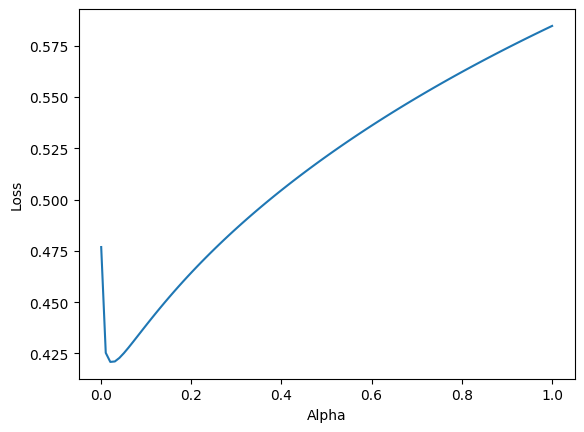

In [560]:
plt.plot(alpha, loss_list)
plt.xlabel('Alpha')
plt.ylabel('Loss');

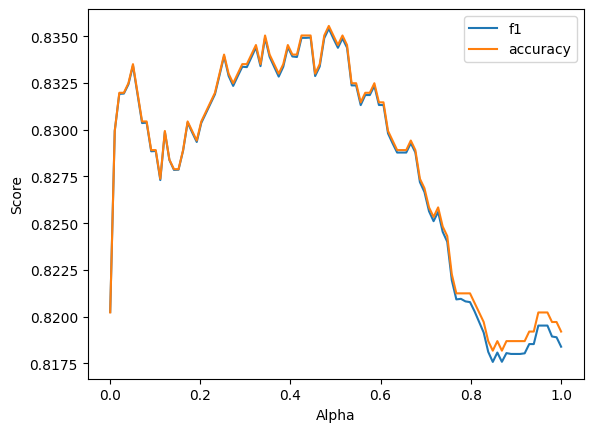

In [561]:
plt.plot(alpha, f1, label='f1')
plt.plot(alpha, accuracy, label='accuracy')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Score');

From the above graph, an alpha of approximately 0.5 may help to improve the model's f1 and accuracy. However, as log loss (the lower the better) is the metric used to score the model, the optimal alpha value should correspond to the lowest log loss values as shown in the DataFrame below. The model is then retrained with the optimised alpha value to evaluate its performance.

In [562]:
pd.DataFrame(loss_list, index=alpha, columns=['log_loss']).sort_values(by='log_loss').head()

,log_loss
0.021182,0.420863
0.031273,0.421093
0.041364,0.422828
0.051455,0.425192
0.011091,0.425287


In [563]:
pd.DataFrame(f1, index=alpha, columns=['f1']).iloc[4]

f1    0.832418
Name: 0.041363636363636366, dtype: float64

A log loss of 0.03 is selected to avoid the sharp increase in log loss values lower than the alpha of 0.02. The f1 value remains acceptable.

In [564]:
model = MultinomialNB(alpha=0.03)

In [565]:
model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.03)

In [566]:
y_pred_proba = model.predict_proba(X_test_tfidf)
y_pred = model.predict(X_test_tfidf)

In [567]:
log_loss(pd.get_dummies(y_test), y_pred_proba)

c:\Users\K\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


0.42095199140375156

In [568]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         EAP       0.81      0.83      0.82       777
         HPL       0.85      0.80      0.83       524
         MWS       0.84      0.86      0.85       657

    accuracy                           0.83      1958
   macro avg       0.84      0.83      0.83      1958
weighted avg       0.83      0.83      0.83      1958



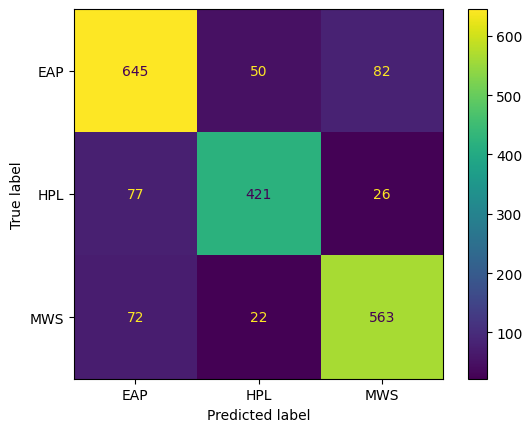

In [569]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

The vectorizer and model is refitted with the full dataset in 'train.csv'.

In [570]:
vect = TfidfVectorizer()
X_tfidf = vect.fit_transform(X)

In [571]:
model.fit(X_tfidf, y)

MultinomialNB(alpha=0.03)

## Test.csv

In [572]:
test_df = pd.read_csv('./test.csv')

In [573]:
test_tfidf = vect.transform(test_df['text'])

In [574]:
submission = pd.DataFrame(model.predict_proba(test_tfidf), index=test_df['id'], columns=["EAP", "HPL", "MWS"])

In [575]:
submission.to_csv('./submission.csv')

The final score (log loss) is 0.38292.